### Weibull density function

$f(y; \theta, \alpha)$ $=$ $\frac{\alpha}{\theta}$ $(\frac{y}{\theta})^{\alpha - 1}$ $exp\{-(\frac{y}{\theta})^{\alpha}\}$

Find $(\theta, \alpha)$

In [1]:
x <- c(225, 171, 198, 189, 189, 135, 162, 135, 117, 162)

In [2]:
weibull_density_func <- function(x, theta, alpha) {
    (alpha / theta)*((x / theta)^(alpha - 1))*exp(-((x/theta)^alpha))
}

In [3]:
loglikelihood_func <- function(x, theta, alpha) {
    total <- 0.
    for (x_i in x) {
        total <- total + log(weibull_density_func(x_i, theta, alpha))
    }

    total
}

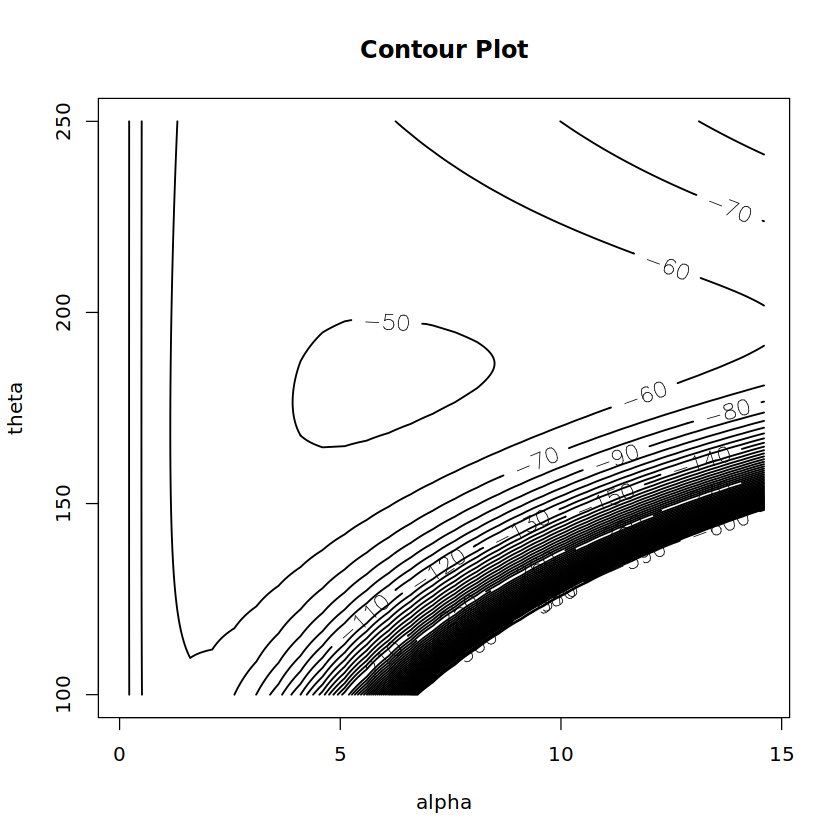

In [4]:
theta_seq <- seq(100., 250., by= 0.5)
alpha_seq <- seq(0.1, 15., by= 0.5)

z <- outer(
    alpha_seq, theta_seq,
    function(alpha, theta) {
        loglikelihood_func(x, theta, alpha)
    }
)

contour(
    alpha_seq, theta_seq, z,
    main = "Contour Plot",
    levels =  c(seq(-600, 0., by = 10)),
    lwd = 1.5,
    xlab = "alpha",
    ylab = "theta",
    labcex = 1.2
)

In [5]:
plot_optimal_point <- function(optimal_point, plot_name) {
   contour(
        alpha_seq, theta_seq, z,
        levels =  c(seq(-600, 0., by = 10)),
        lwd = 1.5,
        xlab = "alpha",
        ylab = "theta",
        labcex = 1.2
    )
    title(main=paste(strwrap(plot_name, width=60), collapse="\n"))
    points(
        x=optimal_point[2], y=optimal_point[1],
        pch = 16, type = "b", col="red", cex = 1.5)
}

In [6]:
grad_def_func <- function(x, params, step=1e-6) {
    val <- loglikelihood_func(x, params[1], params[2])
    theta_grad <- (loglikelihood_func(x, params[1] + step, params[2]) - val) / step
    alpha_grad <- (loglikelihood_func(x, params[1], params[2] + step) - val) / step

    c(theta_grad, alpha_grad)
}

### Partitial first order gradients

$f^{'}_{\theta}$ $=$ $-\frac{n\alpha}{\theta}$ $+$ $\frac{\alpha}{\theta^{(\alpha + 1)}}\sum(x_{i}^{\alpha})$

$f^{'}_{\alpha}$ $=$ $\frac{n}{\alpha}$ + $\sum\log(\frac{x_i}{\theta})$ $-$ $\sum(\frac{x_i}{\theta})^\alpha\log(\frac{x_i}{\theta})$

In [7]:
grad_theta <- function(x, theta, alpha) {
    n <- length(x)
    val1 <- -n*alpha/theta
    val2 <- (alpha/(theta^(alpha + 1)))*sum(x^alpha)

    val1 + val2
}

grad_alpha <- function(x, theta, alpha) {
    n <- length(x)
    val1 <- n/alpha
    val2 <- sum(log(x/theta))
    val3 <- -sum(((x/theta)^alpha)*log(x/theta))

    val1 + val2 + val3
}

first_grad <- function(x, params) {
    c(grad_theta(x, params[1], params[2]),
     grad_alpha(x, params[1], params[2]))
}

### Partitial second order gradients

$f^{''}_{\theta\theta}$ $=$ $\frac{n\alpha}{\theta^2}$ $-$ $\frac{\alpha(\alpha + 1)}{\theta^{\alpha + 2}}$ $\sum(x^{\alpha}_{i})$

$f^{''}_{\alpha\alpha}$ $=$ $-\frac{n}{\alpha^2}$ $-$ $\sum(\frac{x_i}{\theta})^{\alpha}\log^2(\frac{x_i}{\theta})$ 

$f^{''}_{\alpha\theta}$ $=$ $-\frac{n}{\theta}$ $+$ $\frac{\alpha}{\theta}$ $\sum(\frac{x_i}{\theta})^\alpha$ $\log(\frac{x_i}{\theta})$
$+$ $\frac{1}{\theta}\sum(\frac{x_i}{\theta})^\alpha$

In [8]:
# Compute Hessian matrix using definition
# This is used to check Hessian

second_grad_def_func <- function(x, params, step=1e-6) {
    grad_t <- grad_theta(x, params[1], params[2])
    grad_a <- grad_alpha(x, params[1], params[2])
    grad_11 <- (grad_theta(x, params[1] + step, params[2]) - grad_t) / step
    grad_22 <- (grad_alpha(x, params[1], params[2] + step) - grad_a) / step
    grad_12 <- (grad_theta(x, params[1], params[2] + step) - grad_t) / step

    matrix(c(grad_11, grad_12, grad_12, grad_22), nrow=2, byrow=TRUE)
}

In [9]:
second_grad_theta <- function(x, theta, alpha) {
    n <- length(x)
    val1 <- n*alpha / theta^2
    factor <- alpha*(alpha + 1)/theta^(alpha + 2)
    val2 <- sum(x^alpha)

    val1 - factor*val2
}

second_grad_alpha <- function(x, theta, alpha) {
    n <- length(x)
    t <- x/theta
    val1 <- -n/alpha^2
    val2 <- -sum((t^alpha)*(log(t)^2))

    val1 + val2
}

second_grad_alphatheta <- function(x, theta, alpha) {
    n <- length(x)
    t <- x/theta
    val1 <- -n/theta
    val2 <- (alpha/theta)*sum((t^alpha)*log(t)) + sum(t^alpha)/theta

    val1 + val2
}

second_grad <- function(x, params) {
    grad11 <- second_grad_theta(x, params[1], params[2])
    grad22 <- second_grad_alpha(x, params[1], params[2])
    grad21 <- second_grad_alphatheta(x, params[1], params[2])

    matrix(c(grad11, grad21, grad21, grad22), nrow=2, byrow=TRUE)
}

**Gradient checking**

In [23]:
theta <- 11.
alpha <- 1.1

val1 <- grad_def_func(x, c(theta, alpha), step=1e-9)
val2 <- first_grad(x,  c(theta, alpha))
dist <- norm(val1 - val2, type="2")
print(sprintf("First order gradiant error: %f", dist))

hess1 <- second_grad_def_func(x, c(theta, alpha), step=1e-9)
hess2 <- second_grad(x, c(theta, alpha))
err <- norm(hess1 - hess2, type="2")
print(sprintf("Second order gradiant error: %f", dist))

[1] "First order gradiant error: 0.000042"
[1] "Second order gradiant error: 0.000042"


### Naive Newton method

**Updating equation:** $\theta^{(t + 1)}$ $=$ $\theta^{(t)}$ + $d^{(t)}$

where: $d^{(t)}$ $=$ $-H^{-1}f^{'}(\theta^{(t)})$

In [11]:
newton_updating <- function(x, params) {
    grad <- first_grad(x, params)
    hess <- second_grad(x, params)
    d <- -solve(hess, grad)
    
    params <- params + d
}

newton_optimizer <- function(x, max_iter, threshold, params) {
    for (i in 1:max_iter) {
        iter <- i
        old_params <- params
        params <- newton_updating(x, old_params)
        
        if (norm(params - old_params, type="2") <= threshold) {
            return(list(iters=iter, params=params))
        }
    }

    return(list(iters=iter, params=params))
}

Interations: 2, initial points: (160.00, 1.00) optimal points: (147.1617, 3.5879)

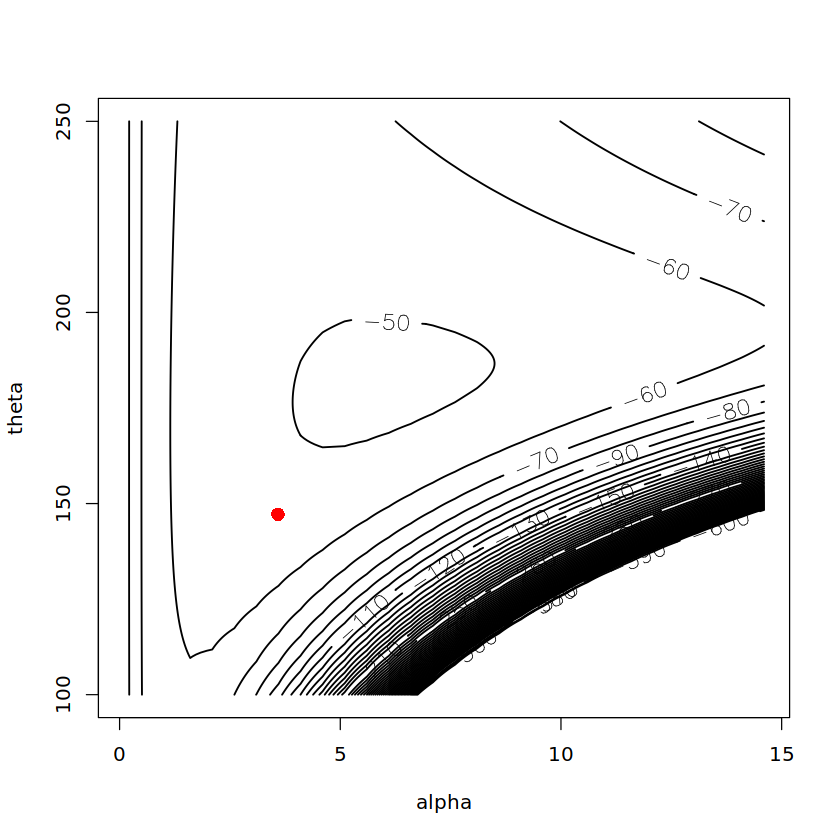

In [12]:
max_iter <- 2
threshold <- 1e-5

init_theta <- 160.
init_alpha <- 1.
init_params <- c(init_theta, init_alpha)

result <- newton_optimizer(x, max_iter, threshold, init_params)
plot_name <- cat(sprintf("Interations: %d, initial points: (%.2f, %.2f)",
                     result$iters, init_params[1], init_params[2]),
                sprintf("optimal points: (%.4f, %.4f)",
                        result$params[1], result$params[2]))
plot_optimal_point(result$params, plot_name)

Interations: 2, initial points: (240.00, 13.00) optimal points: (95.5824, 1.8796)

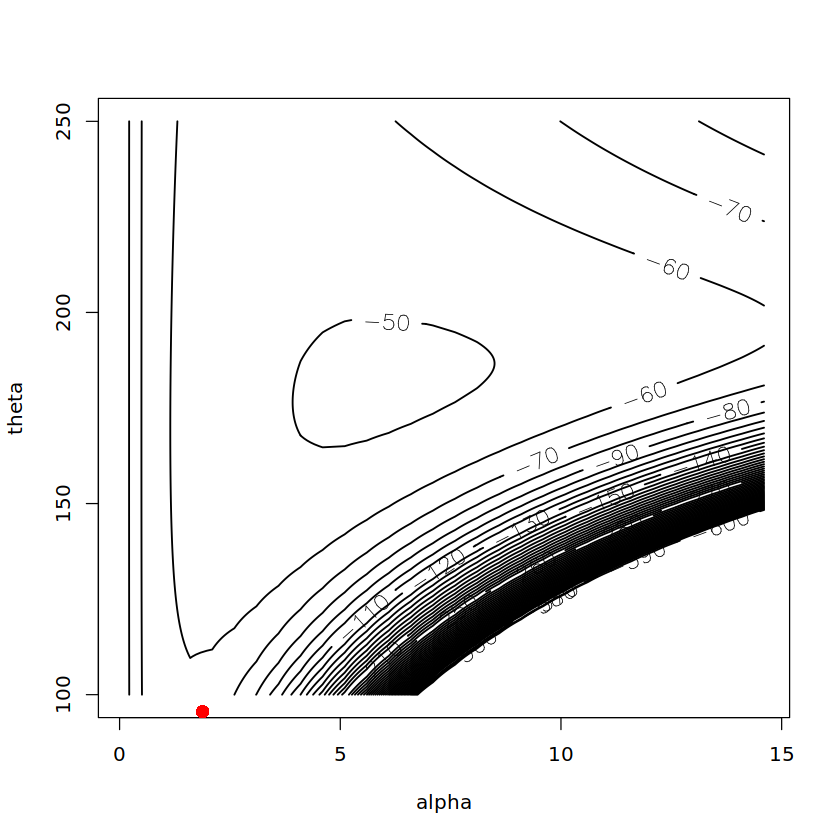

In [13]:
max_iter <- 2
threshold <- 1e-5

init_theta <- 240.
init_alpha <- 13.
init_params <- c(init_theta, init_alpha)

result <- newton_optimizer(x, max_iter, threshold, init_params)
plot_name <- cat(sprintf("Interations: %d, initial points: (%.2f, %.2f)",
                     result$iters, init_params[1], init_params[2]),
                sprintf("optimal points: (%.4f, %.4f)",
                        result$params[1], result$params[2]))
plot_optimal_point(result$params, plot_name)

### Fisher scoring method

**Updating equation:** $\theta^{(t + 1)}$ $=$ $\theta^{(t)}$ + $d^{(t)}$

where: $d^{(t)}$ $=$ $I^{-1}(\theta^{(t)})f^{'}(\theta^{(t)})$

$I^{-1}(\theta)$ is Fisher scoring matrix which is defined as: $I(\theta)$ $=$ $\mathbb{E}[-d^{2}f]$ \
so that: $I(\theta)$ $=$ $-H(\theta)$

In [14]:
fisher_matrix <- function(x, params) {
    -second_grad(x, params)
}

fisher_updating <- function(x, params, a = 1) {
    grad <- first_grad(x, params)
    i_matrix <- fisher_matrix(x, params)
    d <- solve(i_matrix, grad)
    
    params <- params + a*d
}

fisher_optimizer <- function(x, max_iter, threshold, params) {
    for (i in 1:max_iter) {
        iter <- i
        old_params <- params
        params <- fisher_updating(x, old_params)
        
        if (norm(params - old_params, type="2") <= threshold) {
            return(list(iters=iter, params=params))
        }
    }

    return(list(iters=iter, params=params))
}

Interations: 2, initial points: (160.00, 1.00) optimal points: (147.1617, 3.5879)

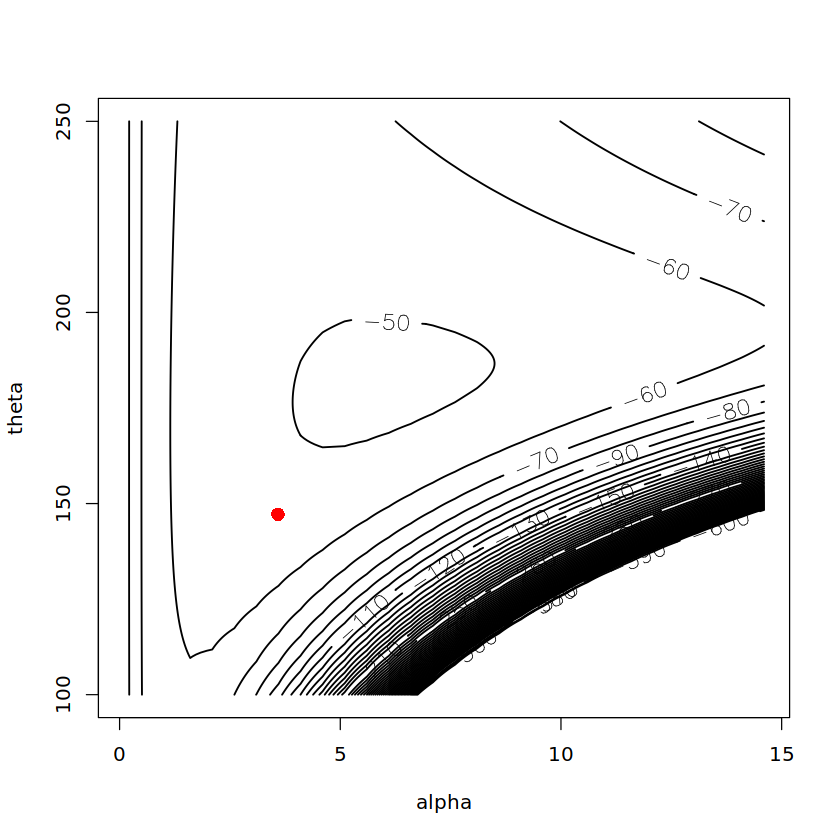

In [15]:
max_iter <- 2
threshold <- 1e-5

init_theta <- 160.
init_alpha <- 1.
init_params <- c(init_theta, init_alpha)

result <- fisher_optimizer(x, max_iter, threshold, init_params)
plot_name <- cat(sprintf("Interations: %d, initial points: (%.2f, %.2f)",
                     result$iters, init_params[1], init_params[2]),
                sprintf("optimal points: (%.4f, %.4f)",
                        result$params[1], result$params[2]))
plot_optimal_point(result$params, plot_name)

Interations: 2, initial points: (240.00, 13.00) optimal points: (95.5824, 1.8796)

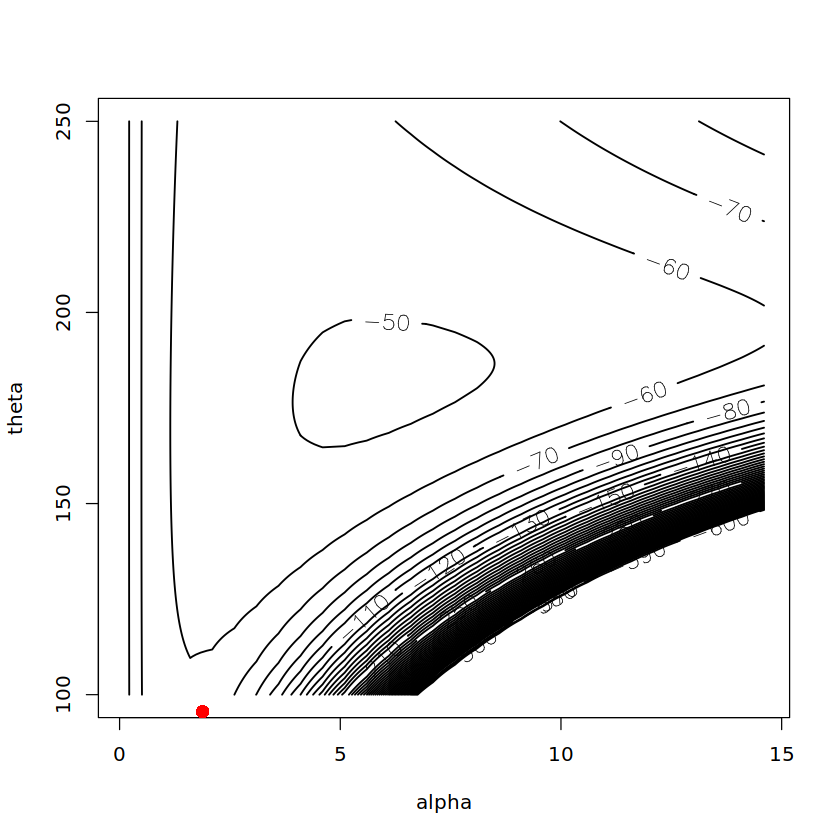

In [16]:
max_iter <- 2
threshold <- 1e-5

init_theta <- 240.
init_alpha <- 13.
init_params <- c(init_theta, init_alpha)

result <- fisher_optimizer(x, max_iter, threshold, init_params)
plot_name <- cat(sprintf("Interations: %d, initial points: (%.2f, %.2f)",
                     result$iters, init_params[1], init_params[2]),
                sprintf("optimal points: (%.4f, %.4f)",
                        result$params[1], result$params[2]))
plot_optimal_point(result$params, plot_name)

### Steepest Ascent

In [17]:
is_greater <- function(params, old_params) {
    f <- loglikelihood_func(x, params[1], params[2])
    old_f <- loglikelihood_func(x, old_params[1], old_params[2])
    
    return(f < old_f)
}

steepest_ascent_optimizer <- function(x, max_iter, threshold, params) {
    for (i in 1:max_iter) {
        iter <- i
        a <- 1.
        old_params <- params
        params <- fisher_updating(x, old_params, a)

        count <- 0
        while(is_greater(params, old_params) && (count < 10)) {
            a <- a / 2.
            param <- fisher_updating(x, old_params, a)
            count <- count + 1
        }
        
        if (norm(params - old_params, type="2") <= threshold) {
            return(list(iters=iter, params=params))
        }
    }

    return(list(iters=iter, params=params))
}

Interations: 2, initial points: (240.00, 13.00) optimal points: (95.5824, 1.8796)

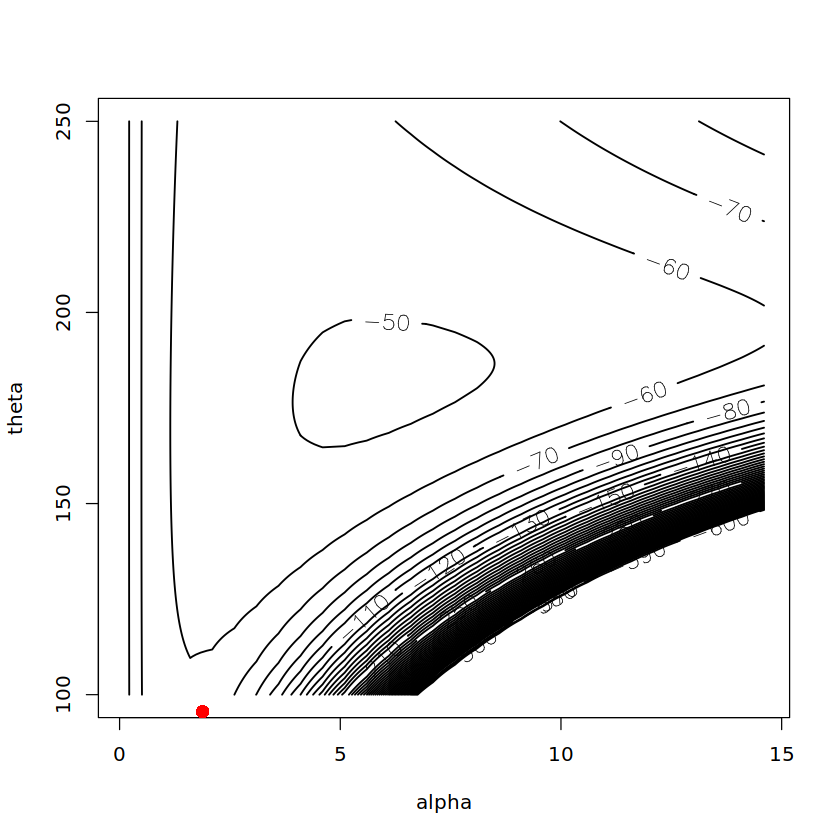

In [18]:
max_iter <- 2
threshold <- 1e-5

init_theta <- 240.
init_alpha <- 13.
init_params <- c(init_theta, init_alpha)

result <- steepest_ascent_optimizer(x, max_iter, threshold, init_params)
plot_name <- cat(sprintf("Interations: %d, initial points: (%.2f, %.2f)",
                     result$iters, init_params[1], init_params[2]),
                sprintf("optimal points: (%.4f, %.4f)",
                        result$params[1], result$params[2]))
plot_optimal_point(result$params, plot_name)

### Quasi-Newton method

In [19]:
newtonlike_updating <- function(params, M, grad, a) {
    d <- solve(M, grad)
    
    params <- params - a*d
}

In [20]:
is_greater <- function(params, old_params) {
    f <- loglikelihood_func(x, params[1], params[2])
    old_f <- loglikelihood_func(x, old_params[1], old_params[2])
    
    return(f < old_f)
}

hess_updating <- function(x, params, old_params, M, old_grad) {
    h <- params - old_params
    u <- first_grad(x, params) - old_grad
    h_trans <- t(h)
    m_h <- M %*% h
    num1 <- m_h %*% t(m_h)
    de1 <- as.numeric(h_trans %*% m_h)
    num2 <- u %*% t(u)
    de2 <- as.numeric(h_trans %*% u)

    M <- M - num1/de1 + num2/de2
}

bfgs_optimizer <- function(x, max_iter, threshold, params) {
    for (i in 1:max_iter) {
        iter <- i
        a <- 1.
        old_params <- params
        grad <- first_grad(x, params)
        M <- -fisher_matrix(x, params)
        params <- newtonlike_updating(old_params, M, grad, a)

        count <- 0
        while(is_greater(params, old_params) && (count < 10)) {
            a <- a / 2.
            param <- newtonlike_updating(old_params, M, grad, a)
            count <- count + 1
        }
        if (norm(params - old_params, type="2") <= threshold) {
            return(list(iters=iter, params=params))
        }
        M <- hess_updating(x, params, old_params, M, grad)
    }

    return(list(iters=iter, params=params))
}

Interations: 2, initial points: (240.00, 13.00) optimal points: (95.5824, 1.8796)

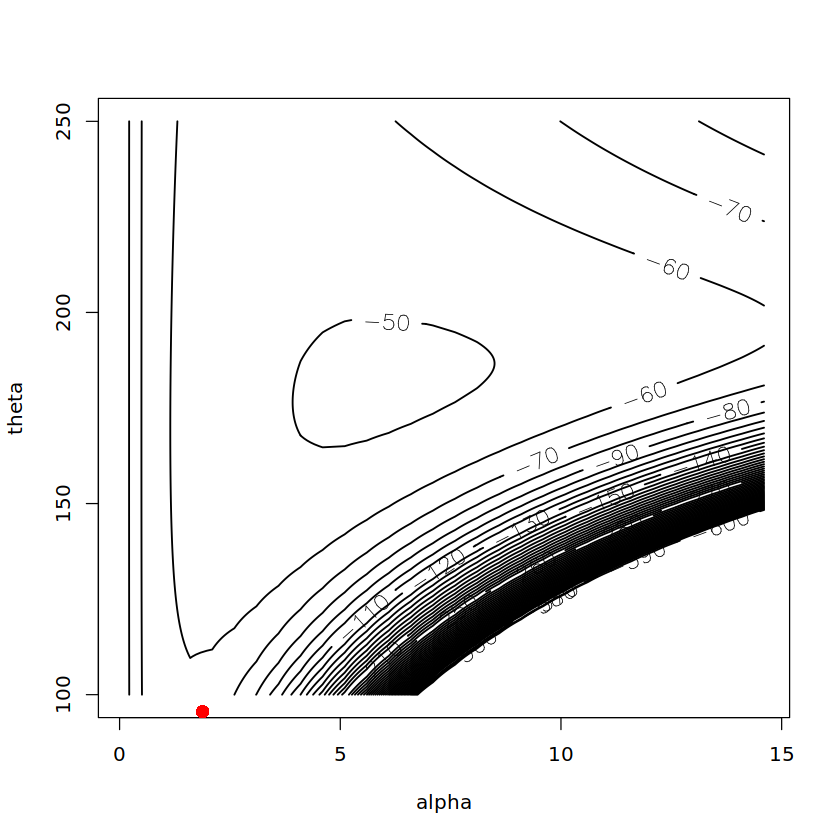

In [21]:
max_iter <- 2
threshold <- 1e-5

init_theta <- 240.
init_alpha <- 13.
init_params <- c(init_theta, init_alpha)

result <- bfgs_optimizer(x, max_iter, threshold, init_params)
plot_name <- cat(sprintf("Interations: %d, initial points: (%.2f, %.2f)",
                     result$iters, init_params[1], init_params[2]),
                sprintf("optimal points: (%.4f, %.4f)",
                        result$params[1], result$params[2]))
plot_optimal_point(result$params, plot_name)